## Librerias

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# I. Fitting Data 


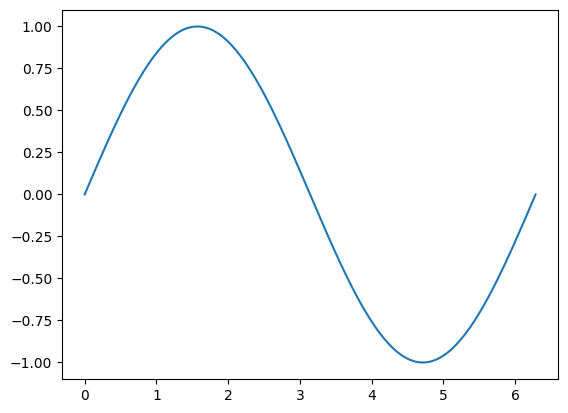

In [8]:
x = np.linspace(0, 2*np.pi, 200)
y = np.sin(x)
plt.plot(x, y)
plt.show()


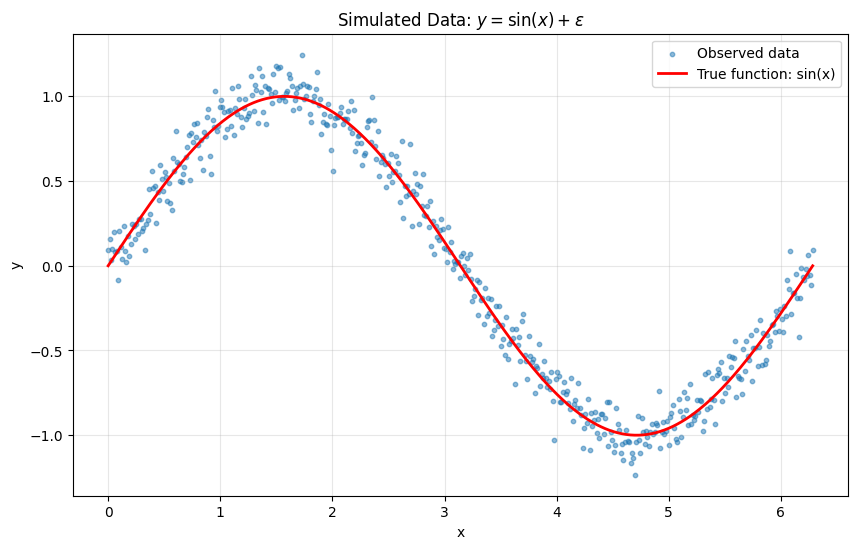

In [11]:

# -------------------------
# 1. Simulación del DGP
# -------------------------

n = 500
x = np.linspace(0, 2*np.pi, n)
eps = np.random.normal(0, 0.1, n)
y = np.sin(x) + eps

# Keras requiere matrices columna
X = x.reshape(-1, 1)

# Gráfico de los datos simulados
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, s=10, label='Observed data')
plt.plot(x, np.sin(x), 'r-', linewidth=2, label='True function: sin(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated Data: $y = \sin(x) + \epsilon$')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../output/simulation_Y.png', dpi=300, bbox_inches='tight')
plt.show()


In [33]:
# -------------------------
# 2. Función para entrenar NNs
# -------------------------

def fit_nn(activations, X, y):
    """
    activations: lista con 3 funciones de activación
    """
    np.random.seed(123)
    model = keras.Sequential([
        layers.Dense(50, activation=activations[0]),
        layers.Dense(50, activation=activations[1]),
        layers.Dense(50, activation=activations[2]),
        layers.Dense(1)  # salida
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=300, verbose=0)

    y_hat = model.predict(X).flatten()
    return y_hat

In [34]:
# -------------------------
# 3. Entrenar modelos
# -------------------------

y_logistic = fit_nn(["sigmoid", "sigmoid", "sigmoid"], X, y)
y_tanh = fit_nn(["tanh", "tanh", "tanh"], X, y)
y_relu = fit_nn(["relu", "relu", "relu"], X, y)

# Activación diferente en cada capa
y_mix = fit_nn(["relu", "tanh", "sigmoid"], X, y)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [35]:
def evaluate_model(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}")
    print(f"\tMSE = {mse:.4f}")
    print(f"\tR^2 = {r2:.4f}\n")

# Evaluar cada modelo
evaluate_model(y, y_logistic, "Modelo: Logistic (sigmoid)")
evaluate_model(y, y_tanh, "Modelo: Tanh")
evaluate_model(y, y_relu, "Modelo: ReLU")
evaluate_model(y, y_mix, "Modelo: Mix (relu - tanh - sigmoid)")

Modelo: Logistic (sigmoid)
	MSE = 0.0105
	R^2 = 0.9794

Modelo: Tanh
	MSE = 0.0113
	R^2 = 0.9778

Modelo: ReLU
	MSE = 0.0097
	R^2 = 0.9809

Modelo: Mix (relu - tanh - sigmoid)
	MSE = 0.0097
	R^2 = 0.9809



# I.I Vizualización

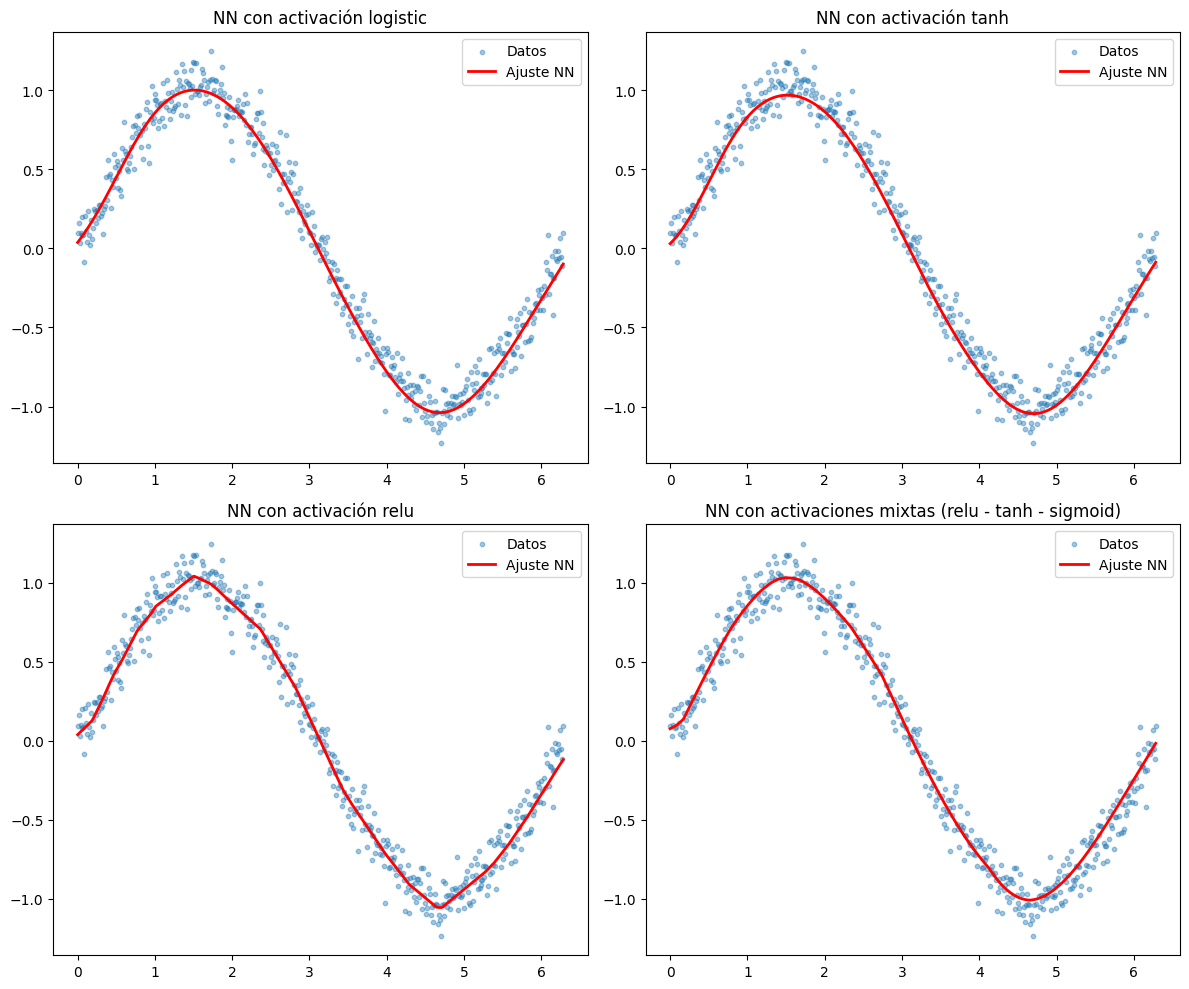

In [36]:
# -------------------------
# 4. Gráficos
# -------------------------

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- 1. LOGISTIC ---
axes[0, 0].scatter(x, y, s=10, alpha=0.4, label="Datos")
axes[0, 0].plot(x, y_logistic, 'r-', linewidth=2, label="Ajuste NN")
axes[0, 0].set_title("NN con activación logistic")
axes[0, 0].legend()

# --- 2. TANH ---
axes[0, 1].scatter(x, y, s=10, alpha=0.4, label="Datos")
axes[0, 1].plot(x, y_tanh, 'r-', linewidth=2, label="Ajuste NN")
axes[0, 1].set_title("NN con activación tanh")
axes[0, 1].legend()

# --- 3. RELU ---
axes[1, 0].scatter(x, y, s=10, alpha=0.4, label="Datos")
axes[1, 0].plot(x, y_relu, 'r-', linewidth=2, label="Ajuste NN")
axes[1, 0].set_title("NN con activación relu")
axes[1, 0].legend()

# --- 4. MIXTA ---
axes[1, 1].scatter(x, y, s=10, alpha=0.4, label="Datos")
axes[1, 1].plot(x, y_mix, 'r-', linewidth=2, label="Ajuste NN")
axes[1, 1].set_title("NN con activaciones mixtas (relu - tanh - sigmoid)")
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../output/nn_simulations.png', dpi=300, bbox_inches='tight')
plt.show()


# II. Learning-rate

El *learning rate* es un hiperparámetro que controla el **tamaño del paso** que da el algoritmo de optimización cuando intenta minimizar la función de pérdida.

En cada actualización de pesos, el modelo sigue la **pendiente** de la función de pérdida (su derivada).  
- Si la pendiente es grande, la pérdida cambia rápidamente.  
- Si la pendiente es pequeña, está cerca de un valle o mínimo local.  

El objetivo es moverse "cuesta abajo" hasta encontrar un **mínimo local**.  
El learning rate determina qué tan grandes son esos pasos:

- **Learning rate muy grande:** los pasos son tan amplios que el algoritmo puede saltarse el mínimo y volverse inestable.
- **Learning rate muy pequeño:** los pasos son demasiado cortos, el entrenamiento es muy lento y puede quedar atrapado en regiones planas.

Cuando entrenamos una red neuronal, el gradiente (derivada) determina **la dirección del movimiento** hacia el mínimo local.

- **Gradiente positivo (> 0):**  
  La pérdida aumenta si el peso aumenta.  
  El modelo debe moverse hacia la izquierda → **restar** `lr * gradiente`.

- **Gradiente negativo (< 0):**  
  La pérdida disminuye si el peso aumenta.  
  El modelo debe moverse hacia la derecha → **sumar** `lr * |gradiente|`.

Por eso, el learning rate debe ser lo suficientemente grande como para avanzar, pero lo bastante pequeño como para no rebotar sobre el mínimo local. Es el equilibrio entre **velocidad** y **estabilidad**.



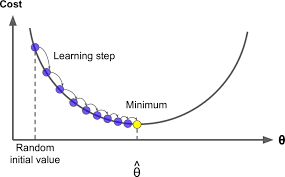

In [47]:
def build_and_train_nn(X, 
                       y, 
                       hidden_layers=1, 
                       activation="relu",
                       lr=0.01, 
                       epochs=300, 
                       batch_size=32):

    model = Sequential()

    # Capa inicial
    model.add(Dense(50, activation=activation, input_dim=X.shape[1]))

    # Capas ocultas adicionales
    for _ in range(hidden_layers - 1):
        model.add(Dense(50, activation=activation))

    # Capa de salida
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=lr)
    
    model.compile(optimizer=optimizer, loss='mse')

    # Guardar historial MSE
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        verbose=0)

    # Predicción final
    y_hat = model.predict(X).flatten()

    mse_history = history.history["loss"]

    return y_hat, model, mse_history

In [48]:

learning_rates = [0.0001, 0.001, 0.01, 0.1]
mse_histories = {}

for lr in learning_rates:    
    _, _, mse_history = build_and_train_nn(
        X, y,
        hidden_layers=1,
        activation="relu",
        lr=lr,
        epochs=300,
        batch_size=32
    )
    mse_histories[lr] = mse_history

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


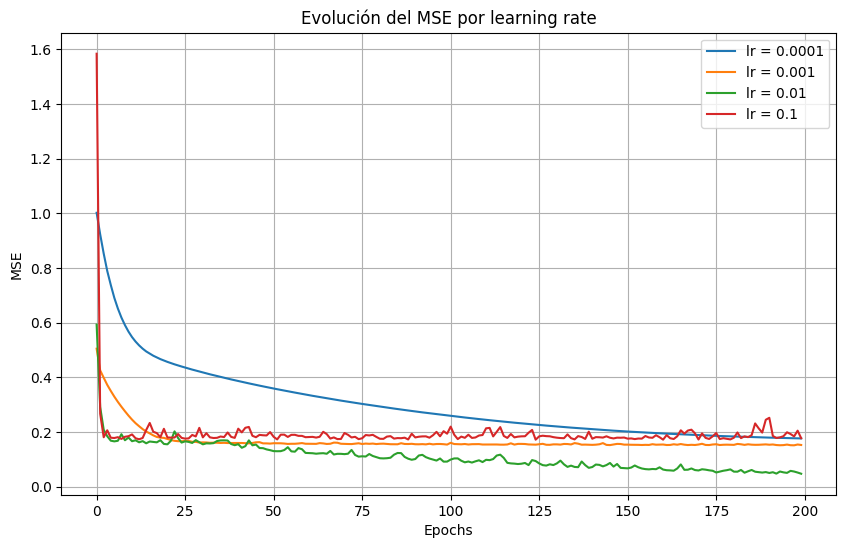

In [ ]:
# Gráfico de la evolución del MSE

plt.figure(figsize=(10, 6))

for lr, mse_history in mse_histories.items():
    plt.plot(mse_history[:200], label=f"lr = {lr}")

plt.title("Evolución del MSE por learning rate")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.savefig('../output/learning_rate_mse.png', dpi=300, bbox_inches='tight')
plt.show()


# 1 Capa Oculta

c:\Users\HP\OneDrive - Universidad del Pacífico\textos\Escritorio\2025-2\Inferencia Causal & ML\CLL\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


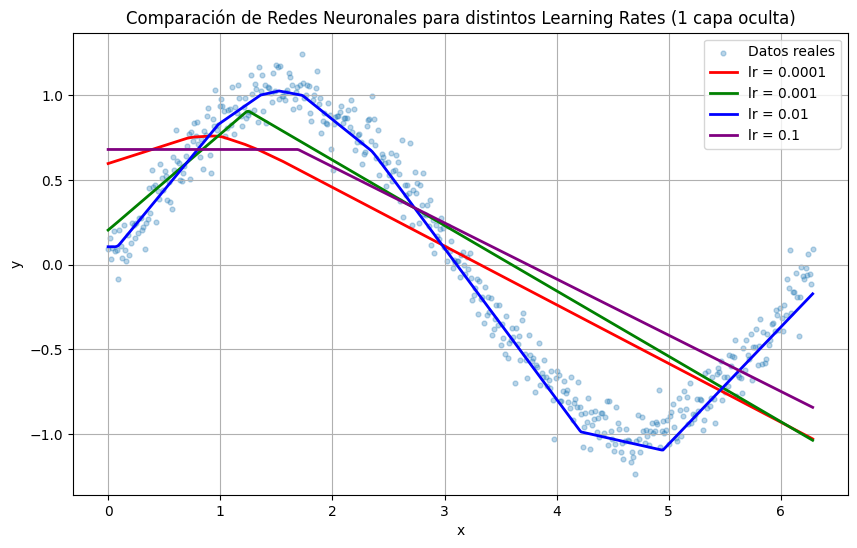

In [51]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, s=12, alpha=0.3, label="Datos reales")

colors = ["red", "green", "blue", "purple"]

for lr, color in zip(learning_rates, colors):
    y_hat, _, _ = build_and_train_nn(
        X, y,
        hidden_layers=1,
        activation="relu",
        lr=lr,
        epochs=300,
        batch_size=32
    )
    plt.plot(x, y_hat, color=color, linewidth=2, label=f"lr = {lr}")

plt.title("Comparación de Redes Neuronales para distintos Learning Rates (1 capa oculta)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


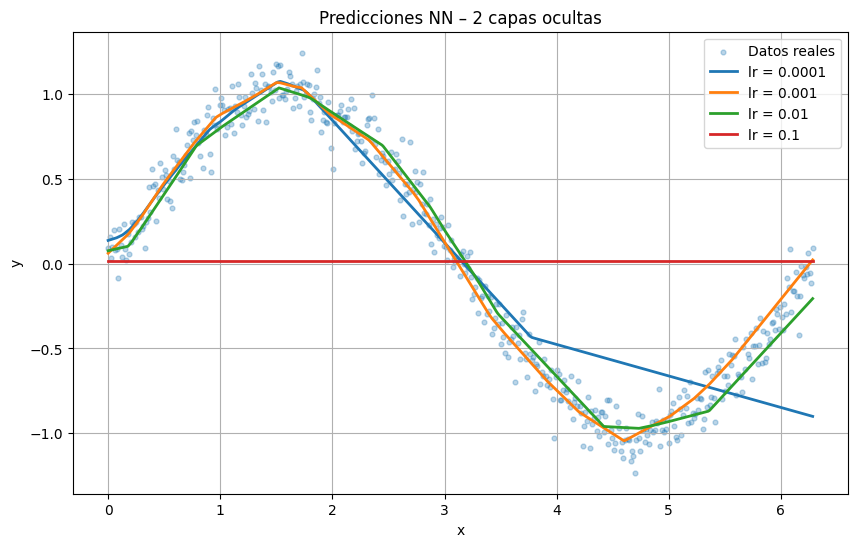

In [54]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, s=12, alpha=0.3, label="Datos reales")

for lr, color in zip(learning_rates, colors):
    y_hat, _, _ = build_and_train_nn(
        X, y,
        hidden_layers=2,
        activation="relu",
        lr=lr,
        epochs=300,
        batch_size=32
    )
    plt.plot(x, y_hat, linewidth=2, label=f"lr = {lr}")

plt.title("Predicciones NN – 2 capas ocultas")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.savefig('../output/nn_2layers_learning_rates.png', dpi=300, bbox_inches='tight')
plt.show()

c:\Users\HP\OneDrive - Universidad del Pacífico\textos\Escritorio\2025-2\Inferencia Causal & ML\CLL\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


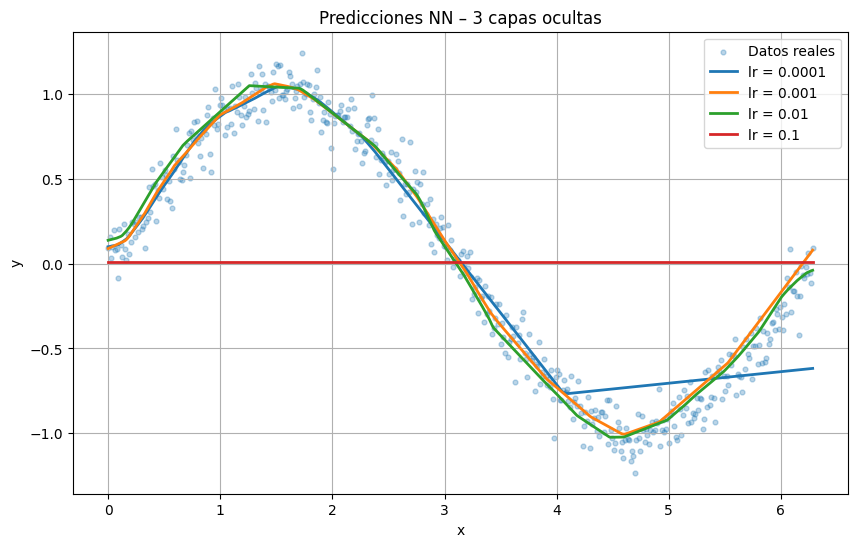

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, s=12, alpha=0.3, label="Datos reales")

for lr, color in zip(learning_rates, colors):
    y_hat, _, _ = build_and_train_nn(
        X, y,
        hidden_layers=3,
        activation="relu",
        lr=lr,
        epochs=300,
        batch_size=32
    )
    plt.plot(x, y_hat, linewidth=2, label=f"lr = {lr}")

plt.title("Predicciones NN – 3 capas ocultas")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.savefig('../output/nn_3layers_learning_rates.png', dpi=300, bbox_inches='tight')
plt.show()
